# Previsão da probabilidade de abstenção do candidato
- Neste notebook, será realizada uma tarefa de classificação, que consiste na previsão da probabilidade de abstenção do candidato no enem (target binário, presente/ausente, 1/0, dados desbalanceados) com base nas variáveis que vimos na análise exploratória de dados. Será aplicado o aprendizado supervisionado, com um conjunto de dados rotulado e um target binário.
- O objetivo consiste em construir um modelo de machine learning capaz de prever, com confiança, a probabilidade de abstenção do candidato. Além disso, avaliar quais variáveis independentes impactam mais e menos a abstenção.
- Para isso, técnicas de limpeza e pré-processamento de dados, treinamento e validação de modelos de machine learning serão aplicadas.
- Todo esse processo será baseado no framework CRISP-DM, podendo envolver ciclos de pré-processamento e validação de modelos repetidamente.
- Pipeline de modelagem:
    - Divisão dos dados em treino, teste e validação.
    - Limpeza e pré-processamento dos dados.
    - Comparação e seleção de modelo potencial com validação cruzada k-fold.
    - Seleção de features.
    - Tunagem de hiperparâmetros.
    - Avaliação final no conjunto de testes (simulando o ambiente de produção).
    - Deploy.
- Finalmente, um modelo de previsão de probabilidade de abstenção pode ser uma ferramenta valiosa para melhorar a eficácia das políticas educacionais e facilitar o processo de organização de exames. Alguns exemplos de aplicações:
    - Identificação de Riscos de Abstenção.
    - Intervenções Preventivas.
    - Aprimoramento da Comunicação.
    - Otimização de Recursos.
    - Planejamento Estratégico.
    - Avaliação do Impacto de Medidas Anteriores.
    - Melhoria da Qualidade do Exame.

#### 1. Importando as bibliotecas

In [2]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, auc, brier_score_loss
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import optuna

# Definições de cores -> todas estão numa escala de mais escura para mais clara.
CINZA1, CINZA2, CINZA3 = '#231F20', '#414040', '#555655'
CINZA4, CINZA5, CINZA6 = '#646369', '#76787B', '#828282'
CINZA7, CINZA8, CINZA9 = '#929497', '#A6A6A5', '#BFBEBE'
AZUL1, AZUL2, AZUL3, AZUL4 = '#174A7E', '#4A81BF', '#94B2D7', '#94AFC5'
VERMELHO1, VERMELHO2, VERMELHO3, VERMELHO4, VERMELHO5 = '#DB0527', '#E23652', '#ED8293', '#F4B4BE', '#FBE6E9'
VERDE1, VERDE2 = '#0C8040', '#9ABB59'
LARANJA1 = '#F79747'
AMARELO1, AMARELO2, AMARELO3, AMARELO4, AMARELO5 = '#FFC700', '#FFCC19', '#FFEB51', '#FFE37F', '#FFEEB2'
BRANCO = '#FFFFFF'

# Visualize all the columns.
pd.set_option('display.max_columns', None)

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

# Utils
from src.modelling_utils import *

#### 2. Coletando os dados
- Considerando que estamos tentando prever a probabilidade de abstenção do candidato, serão incluídos na modelagem todos os dados, como visto na Análise de Abstenção no notebook '2_eda.ipynb'. Dessa forma, incluiremos não só os estudantes que compareceram, mas também aqueles que faltaram ao exame, os quais serão o alvo da modelagem.

In [3]:
# Reading the memory optimized data.
path = 'D:\\MLProjects\\DadosENEM\\clean_df.parquet'
df = pd.read_parquet(path)

#### 2.1 Rápida visualização e informações gerais

In [4]:
df.head()

,faixa_etaria,sexo,estado_civil,status_conclusao_ensino_medio,escola,treineiro,municipio_prova,uf_prova,presenca_cn,presenca_ch,presenca_lc,presenca_mt,nota_cn,nota_ch,nota_lc,nota_mt,lingua,nota_comp1,nota_comp2,nota_comp3,nota_comp4,nota_comp5,nota_redacao,escolaridade_pai,escolaridade_mae,numero_pessoas_em_casa,renda_familiar_mensal,possui_celular_em_casa,possui_computador_em_casa,acesso_internet_em_casa
0,Adulto de meia idade (36-45),M,Casado(a)/União Estável,Concluído,Não respondeu,Não,Brasília,DF,Ausente,Ausente,Ausente,Ausente,0.000000,0.000000,0.000000,0.000000,Inglês,0.0,0.0,0.0,0.0,0.0,0.0,Nunca estudou,Nunca estudou,3,"Até R$ 1.212,00",Não,Não,Não
1,Adulto de meia idade (36-45),M,Casado(a)/União Estável,Concluído,Não respondeu,Não,Brasília,DF,Ausente,Ausente,Ausente,Ausente,0.000000,0.000000,0.000000,0.000000,Inglês,0.0,0.0,0.0,0.0,0.0,0.0,Ensino fundamental completo,Ensino fundamental completo,3,"Acima de R$ 24.240,00",Dois ou mais,Dois ou mais,Sim
2,Jovem adulto (18-24),F,Solteiro(a),Concluído,Não respondeu,Não,Presidente Tancredo Neves,BA,Presente,Presente,Presente,Presente,421.100006,546.000000,498.799988,565.299988,Espanhol,140.0,200.0,120.0,140.0,160.0,760.0,Ensino médio completo,Ensino superior completo,2,"Até R$ 1.212,00",Dois ou mais,Não,Sim
3,Jovem adulto (18-24),M,Solteiro(a),Concluído,Não respondeu,Não,Cariacica,ES,Presente,Presente,Presente,Presente,490.700012,388.600006,357.799988,416.000000,Espanhol,120.0,40.0,40.0,100.0,20.0,320.0,Ensino fundamental incompleto,Nunca estudou,3,Nenhuma Renda,Dois ou mais,Um,Sim
4,Jovem adulto (18-24),M,Não informado,Concluído,Não respondeu,Não,Salinópolis,PA,Ausente,Ausente,Ausente,Ausente,0.000000,0.000000,0.000000,0.000000,Inglês,0.0,0.0,0.0,0.0,0.0,0.0,Ensino fundamental completo,Ensino fundamental incompleto,2,"Até R$ 1.212,00",Um,Não,Não


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3469856 entries, 0 to 3469855
Data columns (total 30 columns):
 #   Column                         Dtype   
---  ------                         -----   
 0   faixa_etaria                   category
 1   sexo                           category
 2   estado_civil                   category
 3   status_conclusao_ensino_medio  category
 4   escola                         category
 5   treineiro                      category
 6   municipio_prova                object  
 7   uf_prova                       category
 8   presenca_cn                    category
 9   presenca_ch                    category
 10  presenca_lc                    category
 11  presenca_mt                    category
 12  nota_cn                        float32 
 13  nota_ch                        float32 
 14  nota_lc                        float32 
 15  nota_mt                        float32 
 16  lingua                         category
 17  nota_comp1                 

In [6]:
print(f'O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.')

O dataset possui 3469856 linhas e 30 colunas.


#### 2.2 Valores nulos e duplicados
- Valores nulos e duplicados, tipos de dados, entre outros processos já foram tratados no notebook '1_data_cleaning.ipynb'. Além disso, muitas variáveis irrelevantes já foram removidas. Iremos realizar daqui para frente, um refinamento com propósitos de modelagem, afinal, a limpeza inicial foi feita direcionada à análise exploratória de dados.

In [7]:
df.isna().sum()

faixa_etaria                     0
sexo                             0
estado_civil                     0
status_conclusao_ensino_medio    0
escola                           0
treineiro                        0
municipio_prova                  0
uf_prova                         0
presenca_cn                      0
presenca_ch                      0
presenca_lc                      0
presenca_mt                      0
nota_cn                          0
nota_ch                          0
nota_lc                          0
nota_mt                          0
lingua                           0
nota_comp1                       0
nota_comp2                       0
nota_comp3                       0
nota_comp4                       0
nota_comp5                       0
nota_redacao                     0
escolaridade_pai                 0
escolaridade_mae                 0
numero_pessoas_em_casa           0
renda_familiar_mensal            0
possui_celular_em_casa           0
possui_computador_em

#### 2.3 Variáveis numéricas e categóricas
- Irei verificar as variáveis numéricas e categóricas.
- Isso influenciará a escolha de encoders e scalers futuramente na etapa de pré-processamento de dados. Cardinalidade é um fator importante a ser considerado.
- Algumas variáveis podem ser transformadas de início. Por exemplo, variáveis binárias podem ter seus valores mapeados a 1 e 0.
- Essas transformações antes do split não configuram data leakage pois são realizadas linha a linha.
- Algumas variáveis podem ser removidas de início.


In [8]:
categorical_features = df.select_dtypes(['category', 'object']).columns.to_list()
numerical_features = df.select_dtypes('number').columns.to_list()
print(f'Há {len(categorical_features)} variáveis categóricas. São elas: {categorical_features}')
print(f'Há {len(numerical_features)} variáveis numéricas. São elas: {numerical_features}')

Há 19 variáveis categóricas. São elas: ['faixa_etaria', 'sexo', 'estado_civil', 'status_conclusao_ensino_medio', 'escola', 'treineiro', 'municipio_prova', 'uf_prova', 'presenca_cn', 'presenca_ch', 'presenca_lc', 'presenca_mt', 'lingua', 'escolaridade_pai', 'escolaridade_mae', 'renda_familiar_mensal', 'possui_celular_em_casa', 'possui_computador_em_casa', 'acesso_internet_em_casa']
Há 11 variáveis numéricas. São elas: ['nota_cn', 'nota_ch', 'nota_lc', 'nota_mt', 'nota_comp1', 'nota_comp2', 'nota_comp3', 'nota_comp4', 'nota_comp5', 'nota_redacao', 'numero_pessoas_em_casa']


In [9]:
print('Cardinalidade das variáveis categóricas: ')
for feature in categorical_features:
    print(f'{feature} ({df[feature].nunique()})', end=', ')

Cardinalidade das variáveis categóricas: 
faixa_etaria (7), sexo (2), estado_civil (5), status_conclusao_ensino_medio (4), escola (3), treineiro (2), municipio_prova (1712), uf_prova (27), presenca_cn (2), presenca_ch (2), presenca_lc (2), presenca_mt (2), lingua (2), escolaridade_pai (7), escolaridade_mae (7), renda_familiar_mensal (10), possui_celular_em_casa (3), possui_computador_em_casa (3), acesso_internet_em_casa (2), 

In [10]:
print('Domínios das variáveis categóricas: ')
print()
for feature in categorical_features:
    print(f'{feature} ({df[feature].value_counts(normalize=True) * 100})')
    print()

Domínios das variáveis categóricas: 

faixa_etaria (faixa_etaria
Jovem adulto (18-24)            55.208516
Adolescente (< 18)              29.193978
Adulto jovem (25-35)            10.210568
Adulto de meia idade (36-45)     3.564932
Meia idade (46-55)               1.373803
Pré aposentadoria (56-65)        0.388345
Idoso (> 66)                     0.059858
Name: proportion, dtype: float64)

sexo (sexo
F    61.019506
M    38.980494
Name: proportion, dtype: float64)

estado_civil (estado_civil
Solteiro(a)                  89.987048
Casado(a)/União Estável       4.767085
Não informado                 3.694707
Divorciado(a)/Separado(a)     1.448619
Viúvo(a)                      0.102540
Name: proportion, dtype: float64)

status_conclusao_ensino_medio (status_conclusao_ensino_medio
Concluído        46.990826
Último ano       37.900247
Cursando         14.747759
Não concluído     0.361168
Name: proportion, dtype: float64)

escola (escola
Não respondeu    62.099753
Pública          31.793510


- O nosso target indicará a prensença ou abstenção do estudante no enem, isto é, iremos definir como presentes aqueles que compareceram em ambos os dias de prova (0) e como ausentes aqueles que faltaram pelo menos um dos dias (1). Após isso, a fim de evitar data_leakage, variáveis representando a presença nas diferentes áreas do conhecimento serão removidas, afinal, não sabemos se um aluno está presente ou não no momento da predição, isso é justamente o que queremos prever. Incluí-las criaria um cenário irreal, superestimando a performance do modelo.
- Variáveis contendo a nota do candidato nas diferentes áreas do conhecimento, redação ou competências da redação serão removidas a fim de evitar data leakage. Da mesma forma, não sabemos qual a nota do candidato em nada no ambiente de produção.
- Possuem característica ordinal as variáveis: faixa_etaria, status_conclusao_ensino_medio, escolaridade_pai, escolaridade_mae, renda_familiar_mensal, possui_celular_em_casa e possui_computador_em_casa.
- A variávei municipio_prova possui altíssima cardinalidade (1712 domínios distintos), não sendo relevante para a análise. Portanto, será removida.
- A variável estado civil será removida pois possui uma variância quase constante. Ela está altamente desbalanceada, com mais de 92% das observações pertencendo à categoria "Solteiro(a)". Além disso, mais de 3% estão como "Não informado", constituindo valores nulos, dado que esse campo era opcional.
- A variável uf_prova também possui alta cardinalidade e será agrupada em uma nova variável chamada "região". Essa nova variável manterá a informação e permitirá melhor aproveitamento pelo modelo, reduzindo a cardinalidade.
- Algumas variáveis podem ser mapeadas para binário ou ordinal, isso será realizado abaixo e/ou na etapa de pré-processamento dos dados.
- Nas variáveis representando a escolaridade do pai e da mãe, há uma categoria "Não sei", indicando valores nulos. Esse valor nulo se deve provavelmente por falta de conhecimento sobre a escolaridade do responsável por parte do candidato. Dito isso, podemos imputá-los ou removê-los. Eu irei imputá-los com o valor mais frequente, uma vez que esse domínio representa uma parte considerável dos nossos dados.
- Variáveis como acesso_internet_em_casa e possui_celular_em_casa estão bastante desbalanceadas. Entretanto, foi possível observar na eda uma clara distinção da distribuição da taxa de abstenção entre categorias dessas variáveis. Portanto, elas serão mantidas, talvez sejam importantes.
- Considerando o significado geral parecido (responsável possui ensino superior), proporções parecidas, e pequena diferença de taxa de abstenção observada na eda, irei combinar as categorias 'Ensino superior completo' e 'Pós-graduação' nas variáveis escolaridade_pai e escolaridade_mae. Isso poderá ajudar o modelo pois, claramente há uma distinção nas notas daqueles cujos pais graduaram-se.
- Dadas as baixas proporções em faixas etárias mais velhas e a semelhante taxa de abstenção, irei unir categorias na variável faixa_etaria da seguinte forma:
    - 'Adolescente (< 18)'.
    - 'Jovem adulto (18-24)'.
    - 'Adulto jovem (25-35)' + 'Adulto de meia idade (36-45)' = 'Adulto (25-45)'.
    - 'Meia idade (46-55)' + 'Pré aposentadoria (56-65)' + 'Idoso (> 66)' = 'Meia idade a idoso (46+)'.
- Apesar de a variável escola possuir 60% das observações registradas como "Não respondeu", irei incluí-la na modelagem. Isso porque foi visto na eda que as categorias pública e privada possuem clara distinção na abstenção. A taxa de abstenção é muito maior entre alunos de escola pública. Portanto, ela pode ajudar o modelo. Uma vez que as observações nulas mencionadas ocorrem por razões aleatórias e dado o seu altíssimo percentual, elas serão tratadas como mais uma categoria dessa variável.
- Irei criar uma variável ordinal acesso_tecnologia que consiste na soma das variáveis acesso_internet_em_casa, possui_celular_em_casa e possui_computador_em_casa, já em formato binário e ordinal. Com isso, eu pretendo informar ao modelo as condições tecnológicas do estudante, uma vez que esse é um fator determinante na abstenção.
- Irei criar uma variável numérica renda_por_pessoa dividindo um valor intermediário nas faixas de renda, já que as faixas possuem intervalos com pouca distância, pelo número de pessoas em casa. Essa variável pode ajudar o modelo, quantificando de fato impactos da renda e do número de residentes na abstenção do candidato.
- Irei categorizar a variável numero_pessoas_casa, uma vez que ela possui valores indo de 1 a 20 e baixíssimas proporções em valores mais altos.

#### 2.4 Limpeza de dados
- Efetuarei os tópicos levantados acima.

In [4]:
# Creating a copy of the dataframe to procceed for data cleaning and next steps.
clean_df = df.copy()

- Mapeamento para binário 1/0 e ordinal 2/1/0.

In [5]:
# Mapping to binary or ordinal.
clean_df['sexo'] = clean_df['sexo'].replace(to_replace={'M': 1, 'F': 0}).astype('int8')
clean_df['lingua'] = clean_df['lingua'].replace(to_replace={'Inglês': 1, 'Espanhol': 0}).astype('int8')
clean_df['treineiro'] = clean_df['treineiro'].replace(to_replace={'Sim': 1, 'Não': 0}).astype('int8')
clean_df['acesso_internet_em_casa'] = clean_df['acesso_internet_em_casa'].replace(to_replace={'Sim': 1, 'Não': 0}).astype('int8')
clean_df['possui_celular_em_casa'] = clean_df['possui_celular_em_casa'].replace(to_replace={'Dois ou mais': 2, 'Um': 1, 'Não': 0}).astype('int8')
clean_df['possui_computador_em_casa'] = clean_df['possui_computador_em_casa'].replace(to_replace={'Dois ou mais': 2, 'Um': 1, 'Não': 0}).astype('int8')

- Feature engineering.

In [6]:
# Creating our target, a feature indicating wheter the student was absent in at least one day of the exam (1).
clean_df['abstencao'] = (clean_df['presenca_lc'] == 'Ausente') | \
                     (clean_df['presenca_ch'] == 'Ausente') | \
                     (clean_df['presenca_cn'] == 'Ausente') | \
                     (clean_df['presenca_mt'] == 'Ausente') 
clean_df['abstencao'] = clean_df['abstencao'].astype('int8')

# Creating a feature indicating the region where the students' exams were applied.
def define_regions(x):
    if x in set(['RS', 'SC', 'PR']):
        return 'Sul'
    elif x in set(['SP', 'RJ', 'MG', 'ES']):
        return 'Sudeste'
    elif x in set(['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE']):
        return 'Nordeste'
    elif x in set(['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO']):
        return 'Norte'
    else:
        return 'Centro-Oeste'

clean_df['regiao'] = clean_df['uf_prova'].apply(define_regions)

# Creating a variable that indicates the student's access to technology.
clean_df['acesso_tecnologia'] = clean_df['acesso_internet_em_casa'] + \
                             clean_df['possui_celular_em_casa'] + \
                             clean_df['possui_computador_em_casa']

# Creating a variable that indicates the income per people at home.
# Mapping income categories to numeric values
income_mapping = {
    'Até R$ 1.212,00': 1212,
    'Nenhuma Renda': 0,
    'R$ 1.818,01 - R$ 3.030,00': (1818 + 3030) / 2,
    'R$ 1.212,01 - R$ 1.818,00': (1212 + 1818) / 2,
    'R$ 3.030,01 - R$ 4.848,00': (3030 + 4848) / 2,
    'R$ 4.848,01 - R$ 7.272,00': (4848 + 7272) / 2,
    'R$ 7.272,01 - R$ 10.908,00': (7272 + 10908) / 2,
    'Acima de R$ 24.240,00': 24240,
    'R$ 18.180,01 - R$ 24.240,00': (18180 + 24240) / 2,
    'R$ 10.908,01 - R$ 18.180,00': (10908 + 18180) / 2
}

# Map income categories to numeric values
clean_df['renda_numerica'] = clean_df['renda_familiar_mensal'].map(income_mapping).astype('int32')

# Calculate income per person
clean_df['renda_por_pessoa'] = (clean_df['renda_numerica'] / clean_df['numero_pessoas_em_casa']).astype('float32')

# Binning number of people at home variable.
clean_df['numero_pessoas_em_casa'] = pd.cut(clean_df['numero_pessoas_em_casa'],
                                            bins=[1, 3, 5, 10, 20],
                                            labels=['1 a 3', '4 a 5', '6 a 10', '11 a 20'],
                                            include_lowest=True)

In [75]:
(clean_df['abstencao'].value_counts(normalize=True)*100).to_frame()

,proportion
abstencao,
0,67.576954
1,32.423046


In [76]:
acesso_tech_absent = clean_df.groupby(['acesso_tecnologia'])[['abstencao']].mean() * 100
acesso_tech_absent.sort_values(by=['abstencao'], ascending=False)

,abstencao
acesso_tecnologia,
0,46.261269
1,43.078847
2,42.188811
3,36.176383
4,28.228469
5,21.070939


In [77]:
people_home_absent = clean_df.groupby(['numero_pessoas_em_casa'])[['abstencao']].mean() * 100
people_home_absent.sort_values(by=['abstencao'], ascending=False)

,abstencao
numero_pessoas_em_casa,
11 a 20,44.877589
6 a 10,37.201351
1 a 3,34.751030
4 a 5,29.454527


- É possível perceber que as categorias de acesso_tecnologia e numero_pessoas_em_casa apresentam distinção nas taxas de abstenção. Portanto, essas variáveis podem ajudar o modelo.

- Dropando variáveis.

In [7]:
# Dropping irrelevant columns.
to_drop = ['municipio_prova', 'presenca_cn', 'presenca_ch', 'presenca_lc', 
       'presenca_mt', 'nota_cn', 'nota_ch', 'nota_lc', 
       'nota_mt', 'nota_comp1', 'nota_comp2', 'nota_comp3', 
       'nota_comp4', 'nota_comp5', 'nota_redacao', 'estado_civil', 
       'uf_prova', 'renda_numerica']

clean_df = clean_df.drop(columns=to_drop)
clean_df.shape

(3469856, 17)

In [8]:
# Assessing which are the remaining columns.
clean_df.columns.tolist()

['faixa_etaria',
 'sexo',
 'status_conclusao_ensino_medio',
 'escola',
 'treineiro',
 'lingua',
 'escolaridade_pai',
 'escolaridade_mae',
 'numero_pessoas_em_casa',
 'renda_familiar_mensal',
 'possui_celular_em_casa',
 'possui_computador_em_casa',
 'acesso_internet_em_casa',
 'abstencao',
 'regiao',
 'acesso_tecnologia',
 'renda_por_pessoa']

- Combinando categorias.

In [9]:
# Combining similar educational level categories.
clean_df['escolaridade_mae'] = clean_df['escolaridade_mae'].replace(to_replace={'Pós-graduação': 'Ensino superior completo'})
clean_df['escolaridade_pai'] = clean_df['escolaridade_pai'].replace(to_replace={'Pós-graduação': 'Ensino superior completo'})

# Combining similar low proportion income categories.
clean_df['renda_familiar_mensal'] = clean_df['renda_familiar_mensal'].replace(to_replace={
    'Até R$ 1.212,00': 'Renda baixa',
    'R$ 1.212,01 - R$ 1.818,00': 'Renda baixa',
    'R$ 1.818,01 - R$ 3.030,00': 'Renda média baixa',
    'R$ 3.030,01 - R$ 4.848,00': 'Renda média baixa',
    'R$ 4.848,01 - R$ 7.272,00': 'Renda média alta',
    'R$ 7.272,01 - R$ 10.908,00': 'Renda média alta', 
    'R$ 10.908,01 - R$ 18.180,00': 'Renda alta',
    'R$ 18.180,01 - R$ 24.240,00': 'Renda alta',
    'Acima de R$ 24.240,00': 'Renda alta'
})

# Combining similar low proportion age categories.
clean_df['faixa_etaria'] = clean_df['faixa_etaria'].replace(to_replace={'Adulto jovem (25-35)': 'Adulto (25-45)', 
                                                                        'Adulto de meia idade (36-45)': 'Adulto (25-45)',
                                                                        'Meia idade (46-55)': 'Meia idade a idoso (46+)',
                                                                        'Pré aposentadoria (56-65)': 'Meia idade a idoso (46+)',
                                                                        'Idoso (> 66)': 'Meia idade a idoso (46+)'})

print(clean_df['escolaridade_mae'].value_counts(normalize=True)*100)
print()
print(clean_df['escolaridade_pai'].value_counts(normalize=True)*100)
print()
print(clean_df['renda_familiar_mensal'].value_counts(normalize=True)*100)
print()
print(clean_df['faixa_etaria'].value_counts(normalize=True)*100)

escolaridade_mae
Ensino médio completo            35.008398
Ensino superior completo         23.784878
Ensino fundamental incompleto    23.533369
Ensino fundamental completo      11.948277
Não sei                           3.163301
Nunca estudou                     2.561778
Name: proportion, dtype: float64

escolaridade_pai
Ensino fundamental incompleto    30.440773
Ensino médio completo            28.841629
Ensino superior completo         15.915761
Ensino fundamental completo      11.186660
Não sei                           9.594577
Nunca estudou                     4.020599
Name: proportion, dtype: float64

renda_familiar_mensal
Renda baixa          46.235262
Renda média baixa    30.011735
Renda média alta     11.878591
Renda alta            5.991459
Nenhuma Renda         5.882953
Name: proportion, dtype: float64

faixa_etaria
Jovem adulto (18-24)        55.208516
Adolescente (< 18)          29.193978
Adulto (25-45)              13.775500
Meia idade a idoso (46+)     1.822006
Name: 

#### 2.5 Classificação desbalanceada
- Estamos lidando com uma tarefa de classificação desbalanceada. O nosso target contempla 32.42% de observações positivas para abstenção (evento de interesse).
- Portanto, algumas estratégias de modelagem serão adotadas:
    - Feature engineering na criação de features que ajudem o modelo a discriminar entre o evento (abstenção, 1) e o não evento.
    - Divisão ESTRATIFICADA dos dados em treino, teste e validação.
    - Validação cruzada k-fold ESTRATIFICADA para acessar a capacidade de generalização do modelo e realizar testes.
    - Utilização de hiperparâmetro class_weight, para permitir que o modelo aprenda melhor os padrões na classe rara (abstenção, 1).
    - Escolha de métricas orientadas a uma avaliação de performance condizente com o desbalanceamento, como PR-AUC, ROC-AUC, recall, precision, f1-score e brier score.
- Apesar de os nossos dados estarem desbalanceados, esse desbalanceamento não é alarmante. Considerando que há mais de 3 milhões de observações, é provável que não tenhamos problemas com essa característica e o modelo seja capaz de aprender bem os padrões por trás da classe rara. Entretanto, para fins de metodologia e garantia de performance, serão seguidas as técnicas supracitadas.

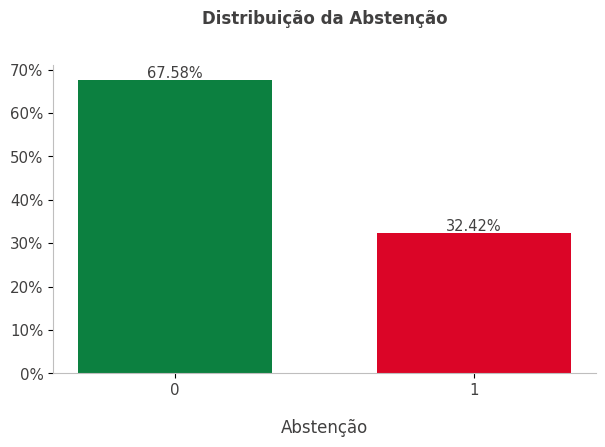

In [81]:
# Grouping the data by sex.
abstencao_grouped = clean_df.groupby(['abstencao'])[['abstencao']].count().rename(columns={'abstencao': 'count'}).reset_index().sort_values(by=['count'], ascending=False)
abstencao_grouped['pct'] = round(abstencao_grouped['count'] / np.sum(abstencao_grouped['count']) * 100, 2) 

# Plotting and customizing.
fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.bar(x=abstencao_grouped['abstencao'], height=abstencao_grouped['pct'], color=[VERDE1, VERMELHO1], width=0.65)
for bar, pct in zip(bars, abstencao_grouped['pct']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{pct}%', ha='center', color=CINZA2, fontsize=10.5)
ax.set_title('Distribuição da Abstenção', color=CINZA2, fontweight='bold', fontsize=12, pad=30)
ax.set_xlabel('Abstenção', labelpad=15, color=CINZA2, fontsize=12)
ax.set_xticks(ticks=abstencao_grouped['abstencao'], labels=abstencao_grouped['abstencao'], color=CINZA2, fontsize=10.8)
ax.set_yticks(ticks=np.arange(0, 71, 10), labels=['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%'] , color=CINZA2, fontsize=10.8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(CINZA9)
ax.spines['bottom'].set_color(CINZA9)
plt.show()

#### 3. Split dos dados em sets de treino, teste e validação
- Os dados de teste são dados que o modelo nunca viu. Por isso, irei realizar o split antes de qualquer coisa. O teste será isolado e utilizado apenas no final para avaliar uma vez o melhor modelo escolhido. Isso garantirá uma avaliação de performance confiável, simulando um ambiente real de produção. Ademais, data leakage também é evitado, aplicando apenas 'transform' neste conjunto.
- Os dados de validação serão utilizados na tunagem de hiperparâmetros para avaliar o modelo treinado em cada configuração. Isso nos ajuda a prevenir o overfitting, evitando decisões baseadas em ajuste excessivo ao conjunto de treinamento.
- Irei especificar o parâmetro stratify=y. Isso fará com que a proporção das classes positiva e negativa do target sejam mantidas em todos os conjuntos, evitando que o desbalanceamento afete as nossas amostras e a nossa avaliação de performance futura. Queremos o fenômeno bem representado em cada uma das amostras.

In [10]:
# Obtaining predictor and target sets.
X = clean_df.drop(columns=['abstencao'])
y = clean_df['abstencao'].copy()

# Setting 80% training, 7.5% test and 7.5% validation. There are a lot of data. Thus, it is not necessary to use a high proportion for test and validation sets.
# Setting stratify=y in order to maintain target classes proportions.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f'Train predictor set shape: {X_train.shape}. Train target set shape: {y_train.shape}')
print(f'Test predictor set shape: {X_test.shape}. Test target set shape: {y_test.shape}')
print(f'Validation predictor set shape: {X_val.shape}. Validation target set shape: {y_val.shape}')

Train predictor set shape: (2949377, 16). Train target set shape: (2949377,)
Test predictor set shape: (260239, 16). Test target set shape: (260239,)
Validation predictor set shape: (260240, 16). Validation target set shape: (260240,)


In [11]:
print(f'Train set target classes proportions: ')
print(y_train.value_counts(normalize=True))
print(f'\nTest set target classes proportions:')
print(y_test.value_counts(normalize=True))
print(f'\nValidation set target classes proportions:')
print(y_val.value_counts(normalize=True))

Train set target classes proportions: 
abstencao
0    0.675769
1    0.324231
Name: proportion, dtype: float64

Test set target classes proportions:
abstencao
0    0.675771
1    0.324229
Name: proportion, dtype: float64

Validation set target classes proportions:
abstencao
0    0.675769
1    0.324231
Name: proportion, dtype: float64


- Perfeito! A divisão dos dados em treino, teste e validação foi feita corretamente e a proporção das classes do target foi mantida em cada um desses conjuntos.

#### 4. Pré-processamento dos dados
- Para treinar algoritmos de machine learning, é necessário aplicar algumas transformações aos dados:
    - Imputar valores nulos: Há alguns valores nulos nas variáveis escolaridade_pai e escolaridade_mae, representados pela categoria 'Não sei'. Considerando que na escolaridade_pai estes representam uma parcela de 8% dos dados (alta), iremos imputá-los com a moda, e não removê-los.
    - Outliers: Há outliers na variável renda_por_pessoa. Entretanto, estes representam valores reais coerentes, e não serão removidos ou tratados.
    - Para algoritmos baseados em árvore, não é necessário feature scaling. Entretanto, uma vez que eu desejo testar diferentes modelos, aplicarei feature scaling nas variáveis categóricas após sua codificação e na variávei renda_por_pessoa. Assim será possível comparar todos os modelos de uma vez.
    - Variáveis numéricas: Alguns algoritmos são sensíveis ao escalonamento de características, pois usam cálculos baseados em distância ou otimizações com gradiente descendente, por exemplo, sendo afetados pela escala. Portanto, aplicarei o StandardScaler. 
    - Para modelos lineares, especialmente a regressão logística, temos algumas suposições que devem ser atendidas, principalmente em casos onde se quer inferir relações a partir dos coeficientes - linearidade das variáveis independentes com o target, ausência de multicolinearidade, normalidade dos resíduos, homoscedasticidade e independência das observações. 
    - Uma vez que há apenas variáveis categóricas, exceto renda_por_pessoa, não há a necessidade de preocupação com multicolinearidade. Além disso, através de técnicas de regularização como Ridge e Lasso, é possível mitigar possíveis ruídos como esse, além de prever o overfitting e realizar uma seleção de features durante o treinamento (Lasso).
    - Durante a análise exploratória de dados, foi possível perceber que, mesmo sendo features categóricas, as diferentes categorias das variáveis estabeleciam uma certa relação linear com o target. Por exemplo, claramente, quanto maior era o nível de escolaridade dos pais do candidato, menor era a taxa de abstenção. Dessa forma, é esperado que o modelo performe bem através de uma simples regressão logística. Isso é bom, uma vez que o output probabilístico da regressão logística é o que mais se aproxima de probabilidades reais calibradas e a sua interpretabilidade é de grande valia.
    - Variáveis categóricas: Algoritmos de machine learning efetuam cálculos matemáticos. Portanto, é necessário converter as variáveis categóricas para numéricas aplicando técnicas de encoding. As principais opções são target encoding, ordinal encoding, e one-hot encoding. Uma observação importante é que one-hot encoding pode ser prejudicial para modelos baseados em árvore, por conta da representação esparsa. 
    - Uma vez que já foram codificadas algumas features acima, será necessário apenas:
        - Para regiao e escola, utilizarei o OneHotEncoder pois há uma baixa cardinalidade, não resultando em grande aumento de dimensionalidade com as dummy variables. Além disso, essas variáveis não apresentam relação ordinal.
        - Todas as outras variáveis possuem relação ordinal. Portanto, utilizarei o OrdinalEncoder. A fim de manter coerente a ordem após aplicar esta transformação (e não apenas por ordem alfabética, como faz a sklearn OrdinalEncoder) e integrá-la a um sklearn pipeline, será introduzido um ColumnTransformer dentro de um pipeline ordinal para conversão correta de cada variável, especificando as suas categorias na ordem correta.

In [11]:
# Assessing which are the remaining categorical features and its unique values.
categorical_features = clean_df.select_dtypes(['category', 'object']).columns.to_list()
print('Domínios das variáveis categóricas: ')
print()
for feature in categorical_features:
    print(f'{feature} ({clean_df[feature].unique().tolist()})')
    print()

Domínios das variáveis categóricas: 

faixa_etaria (['Adulto (25-45)', 'Jovem adulto (18-24)', 'Adolescente (< 18)', 'Meia idade a idoso (46+)'])

status_conclusao_ensino_medio (['Concluído', 'Último ano', 'Cursando', 'Não concluído'])

escola (['Não respondeu', 'Privada', 'Pública'])

escolaridade_pai (['Nunca estudou', 'Ensino fundamental completo', 'Ensino médio completo', 'Ensino fundamental incompleto', 'Ensino superior completo', 'Não sei'])

escolaridade_mae (['Nunca estudou', 'Ensino fundamental completo', 'Ensino superior completo', 'Ensino fundamental incompleto', 'Ensino médio completo', 'Não sei'])

numero_pessoas_em_casa (['1 a 3', '4 a 5', '6 a 10', '11 a 20'])

renda_familiar_mensal (['Renda baixa', 'Renda alta', 'Nenhuma Renda', 'Renda média baixa', 'Renda média alta'])

regiao (['Centro-Oeste', 'Nordeste', 'Sudeste', 'Norte', 'Sul'])



In [12]:
# Defining the features.
ordinal_features = ['faixa_etaria', 'status_conclusao_ensino_medio', 
                    'escolaridade_pai', 'escolaridade_mae', 
                    'numero_pessoas_em_casa', 'renda_familiar_mensal']
nominal_features = ['escola', 'regiao']
scale_features = ['possui_celular_em_casa', 'possui_computador_em_casa', 
                    'acesso_tecnologia', 'renda_por_pessoa']

# Imputing 'Não sei' with the mode.
esc_mae_mode = X_train['escolaridade_mae'].mode()[0]
esc_pai_mode = X_train['escolaridade_pai'].mode()[0]

X_train['escolaridade_mae'] = X_train['escolaridade_mae'].replace(to_replace={'Não sei': esc_mae_mode})
X_train['escolaridade_pai'] = X_train['escolaridade_pai'].replace(to_replace={'Não sei': esc_pai_mode})

X_val['escolaridade_mae'] = X_val['escolaridade_mae'].replace(to_replace={'Não sei': esc_mae_mode})
X_val['escolaridade_pai'] = X_val['escolaridade_pai'].replace(to_replace={'Não sei': esc_pai_mode})

X_test['escolaridade_mae'] = X_test['escolaridade_mae'].replace(to_replace={'Não sei': esc_mae_mode})
X_test['escolaridade_pai'] = X_test['escolaridade_pai'].replace(to_replace={'Não sei': esc_pai_mode})

# Ordinal variables categories orders.
age_categories_ordered = ['Adolescente (< 18)', 'Jovem adulto (18-24)',
                           'Adulto (25-45)', 'Meia idade a idoso (46+)']
status_categories_ordered = ['Não concluído', 'Cursando', 
                             'Último ano', 'Concluído']
educational_level_categories_ordered = ['Nunca estudou', 'Ensino fundamental incompleto', 
                                        'Ensino fundamental completo', 'Ensino médio completo', 
                                        'Ensino superior completo']

people_home_categories_ordered = ['1 a 3', '4 a 5', '6 a 10', '11 a 20']

income_categories_ordered = ['Nenhuma Renda', 'Renda baixa', 
                             'Renda média baixa', 'Renda média alta',
                             'Renda alta']

# Ordinal encoding pipeline.
ordinal_pipe = Pipeline([
    ('ordinal_encoder', ColumnTransformer(
        transformers=[
            ('age', OrdinalEncoder(categories=[age_categories_ordered]), ['faixa_etaria']),
            ('status', OrdinalEncoder(categories=[status_categories_ordered]), ['status_conclusao_ensino_medio']),
            ('dad', OrdinalEncoder(categories=[educational_level_categories_ordered]), ['escolaridade_pai']),
            ('mom', OrdinalEncoder(categories=[educational_level_categories_ordered]), ['escolaridade_mae']),
            ('people', OrdinalEncoder(categories=[people_home_categories_ordered]), ['numero_pessoas_em_casa']),
            ('income', OrdinalEncoder(categories=[income_categories_ordered]), ['renda_familiar_mensal'])
        ]
    )),
    ('std_scaler', StandardScaler())
])

# One hot encoding pipeline.
nominal_pipe = Pipeline([
    ('one_hot_encoder', OneHotEncoder())
])

# Standard Scaler (on the mapped ordinal features) pipeline.
scaling_pipe = Pipeline([
    ('std_scaler', StandardScaler())
])

# Column transformer.
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal_encoding', ordinal_pipe, ordinal_features),
        ('one_hot_encoding', nominal_pipe, nominal_features),
        ('std_scaling', scaling_pipe, scale_features)
    ], remainder='passthrough'
)

# Fitting to the training data and transforming all data we have - training, validation and test sets.
X_train_prepared = preprocessor.fit_transform(X_train, y_train)
X_val_prepared = preprocessor.transform(X_val)
X_test_prepared = preprocessor.transform(X_test)
X_train_prepared.shape, X_val_prepared.shape, X_test_prepared.shape

((2949377, 22), (260240, 22), (260239, 22))

In [81]:
# Obtaining a dataframe of preprocessed data for further interpretation purposes, when analyzing feature importances, for example.
cols = ['faixa_etaria', 'status_conclusao_ensino_medio', 'escolaridade_pai', 
        'escolaridade_mae', 'numero_pessoas_em_casa', 'renda_familiar_mensal',
        'nao_respondeu_escola', 'escola_privada', 'escola_publica',
        'centro_oeste', 'nordeste', 'norte', 'sudeste', 'sul',
        'possui_celular_em_casa', 'possui_computador_em_casa', 
        'acesso_tecnologia', 'renda_por_pessoa', 'sexo', 'treineiro', 
        'lingua', 'acesso_internet_em_casa']
X_train_prep_df = pd.DataFrame(X_train_prepared, columns=cols)
X_val_prep_df = pd.DataFrame(X_val_prepared, columns=cols)
X_test_prep_df = pd.DataFrame(X_test_prepared, columns=cols)
X_train_prep_df

,faixa_etaria,status_conclusao_ensino_medio,escolaridade_pai,escolaridade_mae,numero_pessoas_em_casa,renda_familiar_mensal,nao_respondeu_escola,escola_privada,escola_publica,centro_oeste,nordeste,norte,sudeste,sul,possui_celular_em_casa,possui_computador_em_casa,acesso_tecnologia,renda_por_pessoa,sexo,treineiro,lingua,acesso_internet_em_casa
0,0.168378,0.938371,-0.928419,-1.354261,0.560301,-0.679061,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.465270,-0.957224,-0.350100,-0.514771,0.0,0.0,0.0,1.0
1,-1.262234,-0.432188,-0.103625,0.370253,0.560301,0.352823,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.465270,0.425076,0.564625,-0.296333,0.0,0.0,1.0,1.0
2,0.168378,0.938371,0.721168,1.232511,0.560301,-0.679061,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.465270,-0.957224,-0.350100,-0.514771,0.0,0.0,0.0,1.0
3,-1.262234,-1.802748,0.721168,0.370253,0.560301,0.352823,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.465270,-0.957224,-0.350100,-0.023286,1.0,1.0,1.0,1.0
4,-1.262234,-1.802748,-0.928419,-0.492004,-1.021758,0.352823,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.465270,-0.957224,-0.350100,-0.150708,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2949372,0.168378,0.938371,-0.928419,-1.354261,0.560301,0.352823,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.465270,-0.957224,-0.350100,-0.296333,0.0,0.0,0.0,1.0
2949373,0.168378,-0.432188,0.721168,0.370253,2.142360,-0.679061,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.692086,-0.957224,-1.264825,-0.551177,0.0,0.0,0.0,1.0
2949374,0.168378,0.938371,-0.928419,-1.354261,-1.021758,-0.679061,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.465270,0.425076,0.564625,-0.441958,1.0,0.0,0.0,1.0
2949375,0.168378,0.938371,-0.928419,0.370253,-1.021758,-0.679061,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.465270,0.425076,0.564625,-0.187114,0.0,0.0,1.0,1.0


#### 5. Treinamento, comparação e seleção de modelos - validação cruzada k-fold
- Nesta etapa, irei comparar a performance de diferentes modelos. Para isso, utilizarei a validação cruzada k-fold para treinar cada modelo, avaliando o seu ROC-AUC.
- O meu objetivo aqui é selecionar o(s) modelo(s) promissores, isto é, aqueles que apresentam o maior ROC-AUC na validação cruzada, para seguir para as etapas de tunagem de hiperparâmetros e avaliação final no conjunto de testes, simulando o ambiente de produção.
- O ROC-AUC é uma medida que nos informa a capacidade discriminante do modelo, isto é, a capacidade de discriminar entre ausentes (1) e presentes (0). Ela consiste na área abaixo da curva ROC, que plota tpr (true positive rate, ou recall/sensibilidade) vs fpr (false positive rate, ou 1 - especificidade).
- Na validação cruzada k-fold, dividimos o conjunto de treinamento em k folds, avaliando em cada um dos k-ésimos folds um modelo treinado nos k-1 folds. Isso permitirá que eu obtenha uma medida robusta de como cada um performa, mitigando efeitos da variabilidade dos dados. Além disso, também será evitado o overfitting, uma vez que será possível, de antemão, observar como o modelo desempenha em dados nunca antes vistos.
- Antes de tudo, irei acessar rapidamente a performance de um DummyClassifier, que nada mais é do que um modelo que prevê o valor mais frequente do target para todas as instâncias. Este será o nosso baseline. A performance dos modelos na validação cruzada deve exceder a do DummyClassifier. Caso isso não aconteça, machine learning pode não ser a melhor solução neste caso e algo mais simples deve ser utilizado.

- Dicionário de modelos a serem avaliados.

In [113]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear SVM': LinearSVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier(verbose=-1)
}

- Uma vez que a validação cruzada será utilizada para efeitos de comparação entre modelos e meus recursos computacionais são limitados, irei utilizar uma amostra de 100,000 linhas do conjunto de dados. Esse volume permitirá uma boa generalização dos modelos.
- Aplicarei a amostragem aleatória simples, obtendo um subconjunto representativo. Além disso, dada a propriedade da validação cruzada de mitigar efeitos da variabilidade nos dados, esta é uma ótima estratégia para operar em um dataset desse tamanho.

In [114]:
# Obtaining a simple random sample of 100,000 records from the original data for computational efficiency purposes.
sample_size = 100_000
X_train_sample = X_train.sample(sample_size, random_state=42)
y_train_sample = y_train.sample(sample_size, random_state=42)

# Preprocessing my sample.
X_train_sample_prep = preprocessor.fit_transform(X_train_sample)
X_train_sample_prep.shape, y_train_sample.shape

((100000, 22), (100000,))

- Baseline: Dummy Classifier.

In [115]:
# Fitting and evaluating the Dummy Classifier.
most_freq_model = DummyClassifier(strategy='most_frequent')
val_scores = cross_val_score(most_freq_model, X_train_sample_prep, y_train_sample, cv=5, scoring='roc_auc')
print(f'Dummy Classifier performance: {val_scores.mean()}')

Dummy Classifier performance: 0.5


- Validação cruzada k-fold.

Logistic Regression results: 
--------------------------------------------------
Training score: 0.5517375680524216
Average validation score: 0.6832798462506435
Standard deviation: 0.0014250774282775155
Training time: 0.36762 seconds

Linear SVM results: 
--------------------------------------------------
Training score: 0.5461792650500821
Average validation score: 0.6830572793723935
Standard deviation: 0.001150327521922352
Training time: 27.57748 seconds

K-Nearest Neighbors results: 
--------------------------------------------------
Training score: 0.6742969642664403
Average validation score: 0.610038214367332
Standard deviation: 0.005178313122269533
Training time: 0.008 seconds

Decision Tree results: 
--------------------------------------------------
Training score: 0.7922263330269994
Average validation score: 0.5625297995223131
Standard deviation: 0.004735610604936637
Training time: 0.52307 seconds

Random Forest results: 
--------------------------------------------------
Train

,Model,Average Val Score,Train Score
0,LightGBM,0.688057,0.576042
1,Logistic Regression,0.683280,0.551738
2,Linear SVM,0.683057,0.546179
3,Random Forest,0.615698,0.807448
4,K-Nearest Neighbors,0.610038,0.674297
5,Decision Tree,0.562530,0.792226


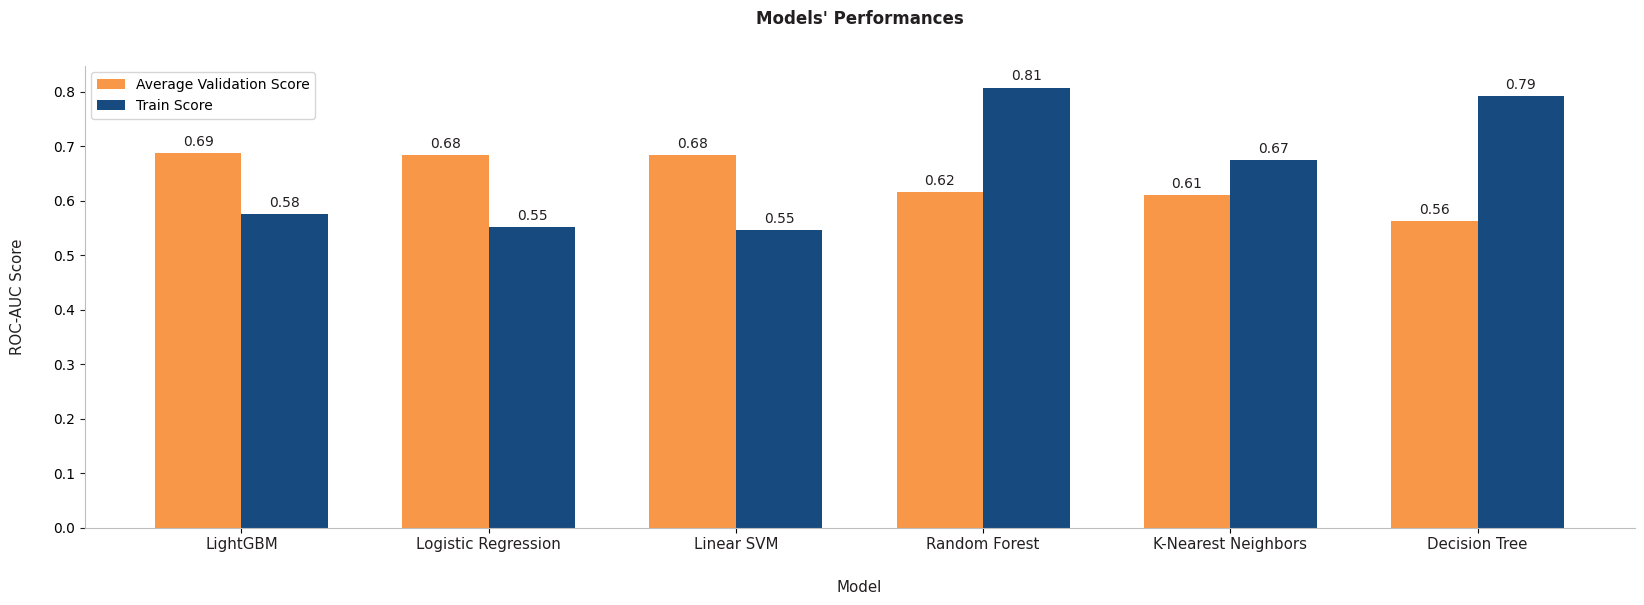

In [116]:
eval_df = evaluate_models_cv_classification(models=models, 
                             X_train=X_train_sample_prep, 
                             y_train=y_train_sample, 
                             n_folds=5)
eval_df

- Machine Learning é uma solução adequada para o problema. O nosso baseline DummyClassifier foi batido.
- Apesar de o melhor modelo ter sido o LightGBM, a diferença entre o seu ROC-AUC score e o ROC-AUC score da Regressão Logística é mínima, igual a 0,005.
- A Regressão Logística é um modelo linear, que obtém a probabilidade de cada instância ser positiva através da função logística da soma ponderada das características de entrada. A função logística retornará um score de probabilidade indo de 0 a 1. Caso a probabilidade de a instância ser positiva seja maior ou igual a 0.5, ela é classificada como tal, do contrário, a instância será atribuída à classe negativa.
- Eu escolherei a Regressão Logística por uma série de motivos:
    - Ela foi o segundo melhor modelo.
    - A Regressão Logística fornece as probabilidades mais próximas de probabilidades reais calibradas. Isso é útil, uma vez que o nosso objetivo consiste de prever a probabilidade de abstenção do candidato.
    - A Regressão Logística apresenta um tempo de treinamento inferior ao tempo de treinamento de modelos ensemble mais complexos, como o LightGBM. Isso trará eficiência ao treinamento do modelo.
    - A Regressão Logística apresenta uma alta interpretabilidade. Através da exponencial dos coeficientes do modelo, é possível verificar qual o aumento percentual na chance de abstenção do candidato para cada aumento de uma unidade na respectiva variável, considerando as outras constantes. O LightGBM, por sua vez, é um modelo caixa preta. Apesar de ser possível utilizar bibliotecas como a shap values para interpretação do seu output, não há comparação com a Regressão Logística nesse aspecto.
    - Através da regularização, é possível minimizar ruídos nos dados, como o efeito de outliers e prevenir o overfitting. A Regressão Logística nos fornece três opções, Ridge, Lasso e Elastic Net. Ademais, a regularização Lasso efetua uma seleção automática de variáveis durante o treinamento, reduzindo o coeficiente de variáveis irrelevantes a zero, gerando um modelo esparso. Isso pode ser uma boa opção, uma vez que eu suspeito que variáveis como o sexo sejam irrelevantes na discriminação entre presentes/ausentes.
    - Foi observado durante a eda uma relação linear entre as diferentes categorias das variáveis e o target, como mencionado no tópico anterior. É provável que o fenômeno seja explicado por essa simples relação e obtenhamos estimativas coeficientes confiáveis.

#### 6. Tunagem de hiperparâmetros
- Irei tunar os hiperparâmetros da Regressão Logística utilizando a otimização bayesiana através da biblioteca optuna.
- A otimização bayesiana realiza buscas inteligentes no espaço de hiperparâmetros do modelo, balanceando o trade-off exploration-exploitation.
- O grid search é ineficiente pois realiza uma busca exaustiva, testando todas as combinações de parâmetros possíveis e não considerando efeitos da interação entre parâmetros. Isso seria ruim no nosso caso, pois o conjunto de dados de treinamento é extenso e alguns parâmetros estão relacionados a outros.
- Em cada iteração, treinaremos o modelo com os parâmetros no conjunto de treinamento e avaliaremos no conjunto de validação, para evitar o overfit decorrente do ajuste excessivo de hiperparâmetros no conjunto de treinamento.
- É importante definir combinações para o hiperparâmetro class_weight, a fim de lidar com o desbalanceamento. Esse hiperparâmetro permitirá que o modelo aprenda melhor os padrões da classe minoritária (ausente (1)) dando maior peso a essas instâncias. Tal peso fará com que o custo da log-loss ao classificá-las erroneamente seja maior, resultando em uma maior atualização nos coeficientes e, portanto, uma melhor aprendizagem nessa classe.
- Além disso, utilizarei hiperparâmetros que implementam um modelo regularizado. Em geral, um pouco de regularização é melhor, ajuda a prevenir o overfitting e pode selecionar variáveis automaticamente no caso da regularização Lasso.
- A tunagem de hiperparâmetros representa um refinamento. O que melhora consideravelmente a performance do modelo é a etapa de feature engineering.

In [124]:
def objective(trial):
    # Define the hyperparameter search space.
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 
                                                         'l2', 
                                                        ]),
        'tol': trial.suggest_float('tol', 1e-5, 1e-1),
        'C': trial.suggest_float('C', 0, 2),
        'max_iter': trial.suggest_int('max_iter', 1000, 3000, step=500),
        'warm_start': trial.suggest_categorical('warm_start', [True, False]),
        'n_jobs': -1,
        'class_weight': 'balanced',
        'solver': 'saga'
    }

    # Train the Logistic Regression model with the sampled hyperparameters.
    model = LogisticRegression(**params)
    model.fit(X_train_prepared, y_train)

    # Make predictions on the validation set.
    y_pred = model.predict(X_val_prepared)

    # Calculate the ROC-AUC score.
    roc_auc = roc_auc_score(y_val, y_pred)

    return roc_auc

# Create an Optuna study
study = optuna.create_study(direction='maximize')

# Optimize the objective function
study.optimize(objective, n_trials=30)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2023-12-30 16:40:29,676] A new study created in memory with name: no-name-6c2f187e-3d86-4636-bdcb-dc8b2edee0dd


[I 2023-12-30 16:40:46,873] Trial 0 finished with value: 0.6348278523581536 and parameters: {'penalty': 'l2', 'tol': 0.010398628276621667, 'C': 1.2964000525044257, 'max_iter': 2000, 'warm_start': False}. Best is trial 0 with value: 0.6348278523581536.
[I 2023-12-30 16:40:59,879] Trial 1 finished with value: 0.6352404403309192 and parameters: {'penalty': 'l1', 'tol': 0.038164696219080765, 'C': 1.8219794639727522, 'max_iter': 2000, 'warm_start': False}. Best is trial 1 with value: 0.6352404403309192.
[I 2023-12-30 16:41:10,136] Trial 2 finished with value: 0.6344835413536019 and parameters: {'penalty': 'l1', 'tol': 0.0504498948057809, 'C': 0.32214310314267647, 'max_iter': 1500, 'warm_start': True}. Best is trial 1 with value: 0.6352404403309192.
[I 2023-12-30 16:41:20,406] Trial 3 finished with value: 0.6342395180806912 and parameters: {'penalty': 'l1', 'tol': 0.049668570983986, 'C': 1.772105799488643, 'max_iter': 2000, 'warm_start': True}. Best is trial 1 with value: 0.6352404403309192.

Best Hyperparameters: {'penalty': 'l1', 'tol': 0.08132164711416587, 'C': 0.49107577496414995, 'max_iter': 2500, 'warm_start': False}


#### 7. Avaliação do modelo final

- Avaliarei a performance do modelo final tunado no conjunto de testes, dados nunca vistos antes pelo modelo, simulando o ambiente de produção.
- Para avaliá-lo, serão analisadas algumas métricas, como o ROC-AUC, PR-AUC, recall, precision e brier score.
- Para o nosso problema, em que temos uma classificação binária desbalanceada, as principais métricas são o PR-AUC e o ROC-AUC. Considerando que estamos focando em probabilidades, o brier score também é interessante:
    - PR-AUC:
        - PR-AUC é a área abaixo da curva precision-recall. 
        - A curva precision-recall é uma representação gráfica do precision e do recall para diferentes valores de threshold.
        - Recall = TP / (TP + FN). Indica para nós quantas instâncias, do total de instâncias positivas, conseguimos prever como positivas.
        - Precision = TP / (TP + FP). Indica para nós, de todas as instâncias preditas como positivas, quantas eram de fato positivas.
        - O PR-AUC foca na classe positiva (classe minoritária). Por isso, é a melhor métrica para o nosso caso.
    - ROC-AUC:
        - ROC-AUC é a área abaixo da curva ROC.
        - A curva ROC é uma representação gráfica do recall/sensitivity/tpr e do fpr/1-specificity/1-tnr para diferentes valores de threshold.
        - A curva ROC nos mostra o poder discriminante do modelo entre as classes positiva e negativa.
        - Ela pode ser muito otimista e não confiável em casos extremos de desbalanceamento. Entretanto, não é o nosso caso, uma vez que há uma quantidade satisfatória de instâncias positivas.
    - Brier score:
        - O brier score mede a diferença quadrática média entre as probabilidades preditas e os valores reais em uma classificação binária.
        - O brier score vai de 0 a 1. 
        - Um menor brier score indica uma melhor performance. Quanto mais próximo de zero, melhor.
        - O brier score penaliza desvios entre as probabilidades preditas e os valores reais, provendo uma medida do poder discriminante e da calibração do modelo.
- Após avaliar o modelo, eu irei interpretar os seus resultados. Particularmente, em se tratando de uma Regressão Logística, analisaremos a exponencial dos seus coeficientes e obteremos insights sobre quais fatores aumentam ou diminuem a chance do candidato se abster no exame.

In [65]:
# Obtaining best model with best parameters found in bayesian optimization.
best_params = {'penalty': 'l1', 
               'tol': 0.08132164711416587, 
               'C': 0.49107577496414995, 
               'max_iter': 2500, 
               'warm_start': False,
               'n_jobs': -1,
               'class_weight': 'balanced',
               'solver': 'saga'}

log_reg = LogisticRegression(**best_params)

# Obtaining training + validation predictor and target sets.
X_train_prep_full = pd.concat([X_train_prep_df, X_val_prep_df])
y_train_full = pd.concat([y_train, y_val])

# Fitting the model to the training data and predicting.
log_reg.fit(X_train_prep_full, y_train_full)
y_pred = log_reg.predict(X_test_prepared)

In [66]:
# Obtaining the predicted probabilities of the candidate being absent.
absent_probas = log_reg.predict_proba(X_test_prepared)[:, 1]

              precision    recall  f1-score   support

           0       0.79      0.59      0.68    175862
           1       0.44      0.68      0.54     84377

    accuracy                           0.62    260239
   macro avg       0.62      0.64      0.61    260239
weighted avg       0.68      0.62      0.63    260239

Brier Score: 0.23


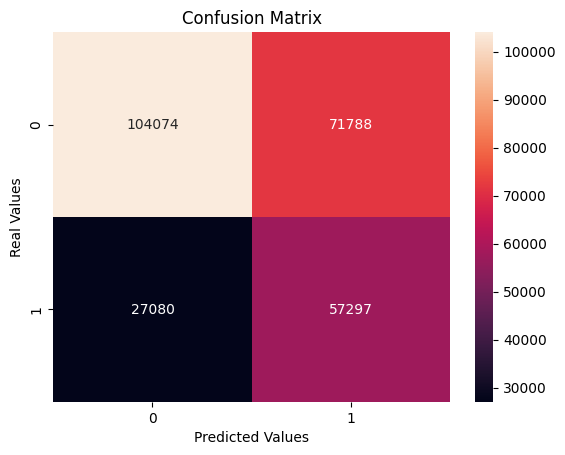

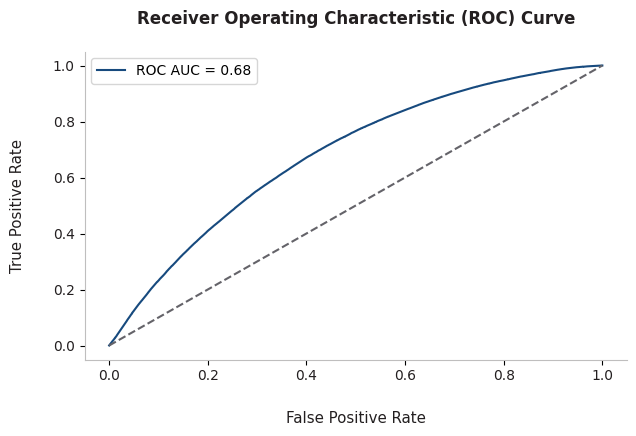

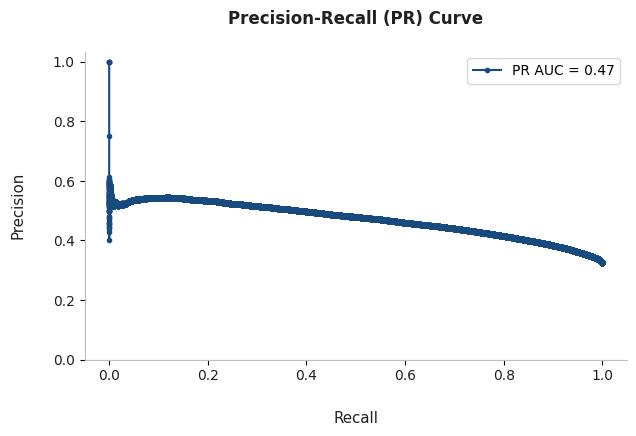

In [67]:
# Evaluating the classifier based on a bunch of metrics.
evaluate_classifier(y_test, y_pred, absent_probas)


Os resultados do modelo são satisfatórios, porém há espaço para melhorias:
- Recall (0,68): O modelo identifica 68% dos ausentes. Na prática, observando a matriz de confusão, o modelo foi capaz de prever corretamente 57.297 dos 84.377 ausentes.
- Precision (0,44): De todos os candidatos preditos como ausentes, 44% se abstiveram de fato. Na prática, observando a matriz de confusão, dos 129.085 candidatos preditos como ausentes, 57.297 deles realmente se abstiveram.
- ROC AUC (0,68): Com um ROC AUC de 0,68, o modelo demonstra uma capacidade satisfatória de diferenciar entre ausentes e presentes.
- PR AUC (0,47): Com um PR AUC de 0,47, o modelo demonstra espaço para melhorias, especialmente na precisão, que foi a métrica mais prejudicada.
- Brier score (0,23): O Brier score está próximo de zero e é satisfatório. Entretanto, também há espaço para melhorias.

- Analisando as probabilidades, a fim de verificar como os scores estão distribuídos entre ausentes (1) e presentes (0).

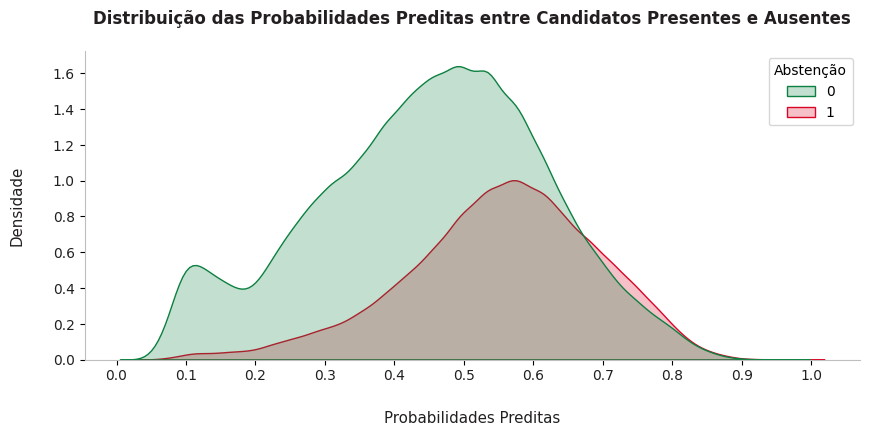

In [70]:
plot_probability_distributions(y_test, absent_probas)

- É possível perceber que não temos uma separação satisfatória entre as distribuições de probabilidade preditas para candidatos presentes e ausentes. Entretanto, para a maioria dos que se abstiveram, estamos prevendo probabilidades altas, o que é bom.
- Talvez seja interessante melhorar a precisão do modelo, que está baixa, e que provavelmente ocasiona essa sobreposição nas probabilidades, uma vez que estamos prevendo probabilidades altas mesmo para instâncias negativas.

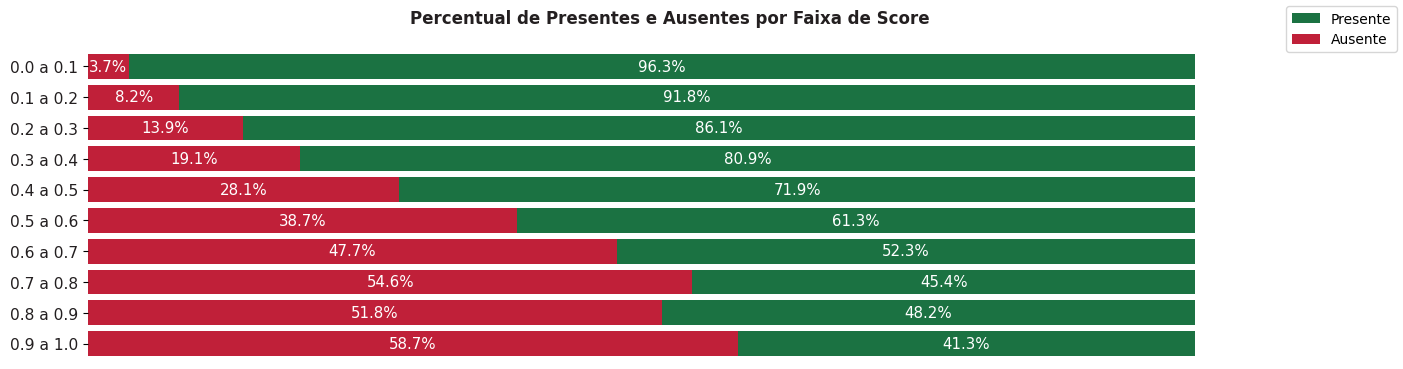

In [78]:
plot_scores_percentages(y_test, absent_probas)

- Nossos scores claramente seguem uma ordenação, o que é bom! É possível perceber que o percentual de candidatos ausentes é muito maior para faixas de probabilidade mais altas. Isso sugere que, apesar de não ser o melhor modelo possível, esta Regressão Logística é sim útil para prever a probabilidade de abstenção de um estudante no enem.

- Finalmente, vamos comparar o ROC AUC do modelo nas amostras de treino, teste e validação, a fim de se certificar que o modelo não está com overfit. 
- Além disso, é importante aplicar a validação cruzada k-fold mais uma vez, a fim de verificar a performance do modelo de Regressão Logística em diferentes conjuntos de dados nunca antes vistos. Isso mitiga efeitos da variabilidade dos dados e nos fornece uma visão concreta da capacidade de generalização do estimador.

In [77]:
# Predicting on train, test and validation sets.
y_pred_train = log_reg.predict_proba(X_train_prepared)[:, 1]
y_pred_val = log_reg.predict_proba(X_val_prepared)[:, 1]
y_pred_test = absent_probas

# K-fold cross validation
cv_scores = cross_val_score(log_reg,
                                X_train_prepared,
                                y_train,
                                scoring='roc_auc',
                                cv=5)
roc_auc_cv = np.mean(cv_scores)

# Obtaining ROC AUC on each of these sets.
roc_auc_train = round(roc_auc_score(y_train, y_pred_train), 2)
roc_auc_test = round(roc_auc_score(y_test, y_pred_test), 2)
roc_auc_val = round(roc_auc_score(y_val, y_pred_val), 2)

# Output a dataframe for better visualization.
roc_auc_sets = pd.DataFrame({'ROC AUC': [roc_auc_train, roc_auc_test, roc_auc_val, roc_auc_cv]}, index=['Train', 'Test', 'Val', 'Cross Val'])
roc_auc_sets

,ROC AUC
Train,0.680000
Test,0.680000
Val,0.680000
Cross Val,0.682386


- Os scores nos conjuntos de treino, teste e validação são aproximadamente iguais. Portanto, o modelo não está com overfitting e generaliza de forma satisfatória para instâncias nunca antes vistas.

- Interpretação dos coeficientes/resultados do modelo de Regressão Logística:
    - Os coeficientes da Regressão Logística apresentam a relação linear entre as variáveis independentes (renda, escolaridade do pai, entre outras) e o log-odds = log(p/1-p). O log-odds representa o logaritmo da razão entre a probabilidade do evento (abstenção do candidato) e a probabilidade do não evento (presença do candidato). Esse quociente nos informa a chance do evento acontecer, quanto maior ele for, maior será essa chance. O logaritmo é utilizado para normalizar e ajustar os valores em uma escala linear.
    - Quanto maior o valor absoluto de um coeficiente, mais forte é o efeito da variável correspondente no log-odds.
    - O sinal de um coeficiente indica a direção do efeito:
        - Positivo, correlação positiva.
        - Negativo, correlação negativa.
    - Coeficientes que são zero indicam que as variáveis correspondentes não são relevantes para o modelo, e eles são eliminados pela penalidade de lasso que foi aplicada (hiperparâmetro penalty = 'l1').
    - Para interpretar os resultados de forma correta, tomamos a exponencial dos coeficientes. Isso nos informará, para cada aumento de uma unidade na respectiva variável, o aumento ou diminuição na chance (p/1-p) de o candidato se abster do exame, considerando todas as outras constantes.

In [82]:
coefficients = log_reg.coef_.tolist()[0]
coef_df = linear_interpretation_df(cols, coefficients, exp=True)
coef_df

,Coeficiente,Correlação,Exponencial
Variável,,,
escola_privada,-1.052792,Negativa,0.348962
treineiro,-0.779011,Negativa,0.458859
nao_respondeu_escola,0.616755,Positiva,1.852905
nordeste,-0.363087,Negativa,0.695526
faixa_etaria,0.297036,Positiva,1.345864
escola_publica,0.185337,Positiva,1.203624
renda_familiar_mensal,-0.176665,Negativa,0.838061
status_conclusao_ensino_medio,-0.159966,Negativa,0.852172
renda_por_pessoa,0.147289,Positiva,1.158688


- A penalidade de Lasso reduziu os coeficientes de variáveis irrelevantes a quase zero. É o caso de acesso_internet_em_casa e sudeste, por exemplo. Estas mesmas variáveis também foram consideradas irrelevantes pelo modelo de Regressão Lasso no notebook '3_modelling_desempenho.ipynb'.
- Algumas das variáveis que mais impactam a chance de abstenção do candidato no enem são: escola_privada, treineiro, nao_respondeu_escola, faixa_etaria, renda_familiar_mensal.
    - Isso faz sentido, uma vez que vimos na eda que:
        - A taxa de abstenção de alunos de escola pública era mais de quatro vezes maior que a de alunos de escola privada.
        - A taxa de abstenção entre candidatos adultos, de meia idade e idosos era maior que a de candidatos adolescentes e jovens adultos.
        - A taxa de abstenção entre candidatos de baixa renda era maior que a de candidatos de maior renda familiar mensal.
        - Treineiros tendem a ter uma menor taxa de abstenção.
    - Todas, exceto faixa_etaria e nao_respondeu_escola apresentam uma correlação negativa com o log-odds. A interpretação pode ser realizada da seguinte maneira:
        - Caso o candidato seja/tenha sido aluno de escola privada, as chances de abstenção diminuem em 65%, considerando as outras variáveis constantes.
        - Caso o candidato seja treineiro, as chances de abstenção diminuem em 55%, considerando as outras variáveis constantes.
        - Para cada aumento de uma unidade na renda familiar mensal, as chances de abstenção diminuem em 17%, considerando as outras variáveis constantes.
    - As variáveis faixa_etaria e nao_respondeu_escola apresentam uma correlação negativa com o log-odds. A interpretação pode ser feita da seguinte forma:
        - Caso o candidato não tenha respondido em que tipo de escola estuda/estudou, as chances de abstenção aumentam em 85%, considerando as outras variáveis constantes.
        - Para cada aumento de uma unidade na faixa_etaria, as chances de abstenção aumentam em 35%, considerando as outras variáveis constantes.

#### 8. Conclusão

- Neste notebook, foi desenvolvido um modelo preditivo de Regressão Logística para predição da probabilidade de abstenção do candidato no enem.
- Considerando que trata-se de uma classificação binária desbalanceada (temos aproximadamente 32% de ausentes contra 68% de presentes), algumas estratégias foram adotadas:
    - Divisão ESTRATIFICADA em treino, teste e validação, para manter a proporção das classes positiva e negativa do target em todas as amostras, permitindo uma avaliação confiável.
    - Validação cruzada k-fold ESTRATIFICADA pelo mesmo motivo.
    - Adoção do hiperparâmetro 'class_weight', aumentando o custo da log loss para erros de classificação de instâncias raras (positivas), resultando em uma maior atualização dos coeficientes e, consequentemente, aprendizado dos padrões dessa classe.
    - Feature engineering na criação de features que ajudem o modelo a discriminar entre o evento (abstenção, 1) e o não evento.
    - Escolha de métricas orientadas a uma avaliação de performance condizente com o desbalanceamento, como PR-AUC, ROC-AUC, recall, precision, f1-score e brier score.
- Foram consideradas diversas variáveis na construção do modelo. Os insights obtidos na etapa de análise exploratória de dados serviram de guia para tarefas de limpeza e pré-processamento de dados, necessárias para a aplicação de algoritmos de machine learning.
- Após a limpeza, avaliamos através da validação cruzada k-fold modelos potenciais, a fim de selecionar um deles para a tunagem de hiperparâmetros e avaliação final no conjunto de testes, simulando o ambiente de produção. O modelo selecionado foi a Regressão Logística, por uma série de fatores:
    - Obteve o segundo melhor ROC AUC score na validação cruzada, perdendo apenas para o LightGBM.
    - Possibilita o treinamento e predição mais rápidos, trazendo eficiência.
    - Grau de interpretabilidade fornecido pelos coeficientes.
    - Probabilidades mais próximas das probabilidades reais calibradas.
    - Regularização e seleção automática de variáveis através da penalidade LASSO, penalty='l1'.
- O resultado obtido foi satisfatório, porém há espaço para melhorias:
    - Obtivemos um ROC AUC de 0.68, indicando que o modelo possui um poder discriminante satisfatório entre as classes positiva e negativa.
    - Obtivemos um Recall 0.68, de modo que o modelo identifica corretamente 68% dos ausentes.
    - O modelo apresenta ordenação nos escores, com faixas de probabilidade mais altas contendo mais ausentes.
    - Os erros nas amostras de treino, teste e validação são similares, indicando que o modelo não está com overfitting e generaliza de forma satisfatória para instâncias nunca antes vistas.
- Os coeficientes foram interpretados e algumas das variáveis mais importantes foram: escola_privada, treineiro, nao_respondeu_escola, faixa_etaria, renda_familiar_mensal.
    - Isso faz sentido, uma vez que vimos na eda que:
        - A taxa de abstenção de alunos de escola pública era mais de quatro vezes maior que a de alunos de escola privada.
        - A taxa de abstenção entre candidatos adultos, de meia idade e idosos era maior que a de candidatos adolescentes e jovens adultos.
        - A taxa de abstenção entre candidatos de baixa renda era maior que a de candidatos de maior renda familiar mensal.
        - Treineiros tendem a ter uma menor taxa de abstenção.
- A interpretação completa encontra-se no notebook. Foi possível observar que, por exemplo, caso o candidato estude/tenha estudado em escola privada, a chance de abstenção diminui em 65%, considerando as outras variáveis constantes.
- Para os próximos passos, temos o deploy do modelo em produção.